# Generazione di volti

## Obiettivo

In questa seconda parte di laboratorio, alleneremo un modello di intelligenza artificiale generativa (nello specifico un *Variational Autoencoder Condizionale*) per la generazione di facce realistiche.

A tale scopo abbiamo allenato nostro modello modello utilizzando come dati le fotografie presenti nel dataset pubblicamente disponibile [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). Questa raccolta contiene foto di volti di personaggi dello spettacolo, comprensive di una loro descrizione attraverso attributi quantitativi.

### Import delle librerie necessarie

In [1]:
from typing import List
from typing import Optional
from typing import Tuple
from typing import Union

In [2]:
import torch as th
from torch import nn
from torchvision.utils import make_grid
from safetensors.torch import load_model

In [3]:
import matplotlib.pyplot as plt

## Il modello

Questa volta non ci sarà necessità di allenare un modello, come invece abbiamo dovuto fare in precedenza (lo abbiamo già fatto noi per voi!).

Nella cella successiva viene scaricato un file contenente il modello già allenato.

In [4]:
!wget "https://bucket.ballarin.cc/aimldl/sdiafest2024/celeba_cvae_v12.safetensors" > /dev/null 2>&1

Nelle celle qui di seguito sono riportate alcune classi e funzioni necessari per una più agevole definizione del modello. Per motivi di semplicità e tempo non ci soffermiamo su questa parte.

In [5]:
class Concatenate(nn.Module):
    def __init__(self, dim: int = 1):
        super().__init__()
        self.dim: int = dim

    def forward(self, tensors: Union[Tuple[th.Tensor, ...], List[th.Tensor]]):
        return th.cat(tensors, dim=self.dim)

In [6]:
class DuplexLinearNeck(nn.Module):
    def __init__(self, in_dim: int, latent_dim: int):
        super().__init__()
        self.x_to_mu: nn.Linear = nn.Linear(in_dim, latent_dim)
        self.x_to_log_var: nn.Linear = nn.Linear(in_dim, latent_dim)

    def forward(
        self, xc: Union[Tuple[th.Tensor, ...], List[th.Tensor]]
    ) -> Tuple[th.Tensor, th.Tensor]:
        cxc: th.Tensor = th.cat(xc, dim=1)
        return self.x_to_mu(cxc), self.x_to_log_var(cxc)

In [7]:
class GaussianReparameterizerSampler(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, z_mu: th.Tensor, z_log_var: th.Tensor) -> th.Tensor:
        return z_mu + th.randn_like(z_mu, device=z_mu.device) * th.exp(z_log_var * 0.5)

Ora definiamo la struttura della rete neurale che costituirà la parte di **Encoder** nel nostro modello.

In [8]:
def make_encoder_base() -> nn.Module:
    return nn.Sequential(
        nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(32, affine=True),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64, affine=True),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128, affine=True),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256, affine=True),
        nn.LeakyReLU(0.2),
    )

Similmente, definiamo la rete che costituirà il **decoder** del nostro modello.

In [9]:
def make_decoder_base(lat_size: int = 128, cond_size: int = 40) -> nn.Module:
    return nn.Sequential(
        nn.Linear(lat_size + cond_size, 256 * 4 * 4),
        nn.LeakyReLU(0.2),
        nn.Unflatten(1, (256, 4, 4)),
        nn.ConvTranspose2d(
            256, 256, 3, stride=2, padding=1, output_padding=1, bias=False
        ),
        nn.BatchNorm2d(256, affine=True),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(
            256, 128, 3, stride=2, padding=1, output_padding=1, bias=False
        ),
        nn.BatchNorm2d(128, affine=True),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(
            128, 64, 3, stride=2, padding=1, output_padding=1, bias=False
        ),
        nn.BatchNorm2d(64, affine=True),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(
            64, 32, 3, stride=2, padding=1, output_padding=1, bias=False
        ),
        nn.BatchNorm2d(32, affine=True),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1, bias=True),
        nn.Sigmoid(),
    )

Infine, la classe `CelebACVAE` rappresenta il nostro modello vero e proprio, costituito da Encoder e Decoder. Notiamo che la dimensione dello spazio latente `lat_size` è stata fissata a 128, mentre la dimensione originale di ciascuna immagine è di 4096 (64 x 64 pixel) x 3 canali ciascuno. A questa vanno aggiunte ulteriori 14 dimensioni corrispondenti alle variabili di attributo scelte.

In [10]:
class CelebACVAE(nn.Module):
    def __init__(self, lat_size: int = 128, cond_size: int = 14):
        super().__init__()
        self.lat_size: int = lat_size
        self.cond_size: int = cond_size
        self.encoder: nn.Module = make_encoder_base()
        self.neck: nn.Module = DuplexLinearNeck(4096 + self.cond_size, self.lat_size)
        self.sampler: nn.Module = GaussianReparameterizerSampler()
        self.decoder: nn.Module = nn.Sequential(
            Concatenate(), make_decoder_base(self.lat_size, self.cond_size)
        )

    def sample_eval(self, z: Optional[th.Tensor], c: th.Tensor) -> th.Tensor:
        with th.no_grad():
            return (
                self.decoder((z, c))
                if z is not None
                else self.decoder(
                    (th.randn((c.shape[0], self.lat_size), device=self.device), c)
                )
            )

    @property
    def device(self) -> th.device:
        return next(self.parameters()).device

## Inferenza

Nelle celle seguenti, definiamo alcune variabili utili a definire le caratteristiche del processo generativo che vogliamo seguire...

In [11]:
DEVICE_AUTODETECT: bool = True
IMG_SHAPE: Tuple[int, int, int] = (3, 64, 64)
TEST_BS: int = 32
LATENT_SIZE: int = 128
CONDITION_SIZE: int = 15

In [12]:
device = th.device("cuda" if (th.cuda.is_available() and DEVICE_AUTODETECT) else "cpu")

Per inizializzare il nostro modello già allenato carichiamo il contenuto del file scaricato prima, ovvero i parametri di un modello allenato a sufficienza, con la stessa struttura definita in precedenza. Per fare questo, usiamo la funzione `load_model`.

In [13]:
model = CelebACVAE(lat_size=LATENT_SIZE, cond_size=CONDITION_SIZE).to(device)

In [14]:
_ = load_model(model, "./celeba_cvae_v12.safetensors")

In [15]:
_ = model.to(device)
_ = model.eval()

### Cominciamo a generare!

Procediamo ora alla parte di generazione vera e propria. Abbiamo strutturato il nostro modello in modo che sia possibile generare volti in maniera **condizionata** rispetto agli attributi che accompagnano le varie foto.

La tabella qui di seguito riportata reca il nome di ciascun attributo, il suo indice nella lista (che andremo ad utilizzare attivamente nel codice), il suo eventuale valore di default (alcuni attributi devono essere fissati per garantire una buona qualità!) ed eventuali note associate.

I valori devono essere in ogni caso pensati come appartenenti all'intervallo $[-1.5, +1.5]$.

Ovviamente, nessuno impedisce di uscirvi... tuttavia, non è garantita la buona qualità del risultato!

| Indice | Attributo         | Valore Def.      | Note|
|-------|-------------------|------------|---------|
| 0     | Ombra | 0.5        |Fissato per qualità immagine|
| 1     | Calvizie              | Modificabile |Suggested sweeping set #1 (+)|
| 2     | Frangia             | Modificabile |Suggested sweeping set #1 (-)|
| 3     | Capelli Neri        | Modificabile |Suggested sweeping set #2 (+)|
| 4     | Capelli Biondi       | Modificabile |Suggested sweeping set #2 (-)|
| 5     | Sfocatura            | -2.0       |Fissato per qualità immagine|
| 6     | Rotondità            | Modificabile | Suggested sweeping set #3 (+) |
| 7     | Occhiali        | Modificabile |Suggested exclusion set #4|
| 8     | Trucco      | Modificabile |Suggested exclusion set #4|
| 9     | Sesso              | Modificabile | Valori alti = M; bassi = F|
| 10    | Barba | Modificabile |Valori alti = volto glabro; bassi = barbuto|
| 11    | Faccia Ovale  |Modificabile |Suggested sweeping set #3 (+)|
| 12    | Stempiatura | Modificabile |Suggested sweeping set #1 (+)|
| 13    | Sorriso           | Modificabile ||
| 14    | Età             | Modificabile | Valori alti = giovane; bassi = vecchio|

Nella cella seguente, fissiamo i parametri che garantiscono una buona qualità delle immagini risultanti. I parametri rimanenti sono inizializzati ad un valore di default pari a $0.5$.

In [16]:
condition = th.zeros(TEST_BS, CONDITION_SIZE).to(device) + 0.5
condition[:, 0] = 0.5
condition[:, 5] = -2.0

Cominciamo generando alcune immagini d'esempio, fissando solo le condizioni di default. Ricordiamo che il processo generativo avviene tramite campionamento (guidato) dallo spazio latente, seguito dalla parte di decodifica.

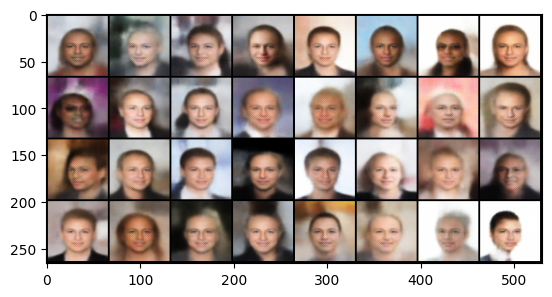

In [17]:
with th.no_grad():
    img = model.sample_eval(z=None, c=condition.to(device))
    _ = plt.imshow(make_grid(img).permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

A questo punto cerchiamo un volto su cui sperimentare! La cella seguente genera un volto in modo casuale ogni volta che viene eseguita. Potete eseguira la cella quante volte desiderate, fino a che non trovate una faccia che *faccia* 🙃 al caso vostro!

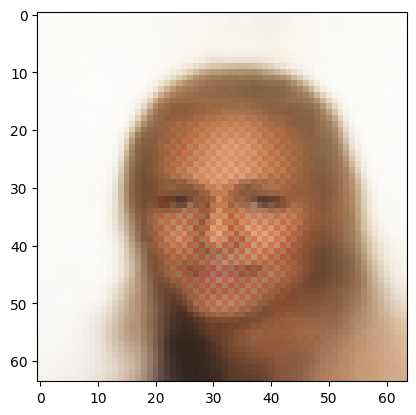

In [22]:
z = th.randn(1, LATENT_SIZE).to(device)
c = th.zeros(1, CONDITION_SIZE).to(device) + 0.5
condition[:, 0] = 0.5
condition[:, 5] = -2

with th.no_grad():
    img = model.sample_eval(z=z, c=c)
_ = plt.imshow(img[0].permute(1, 2, 0).cpu().detach().numpy())
plt.show()

myz = z.detach()

Similmente a quanto fatto nel notebook precedente, con il codice seguente possiamo visualizzare meglio l'effetto del condizionamento *interpolando* le caratteristiche del volto scelto attraverso diverse intensità delle caratteristiche scelte. In questo caso sceglieremo due attributi tramite i loro indici, `att_idx_1` e `att_idx_2`, su cui condizioneremo contemporaneamente la generazione di nuovi volti. A ciascun campione, corrispondono vari livelli di intensità di ciascuna caratteristica, percorsi in senso opposto.

Scegliendo ad esempio `att_idx_1 = 3` (Capelli Neri) e
`att_idx_2 = 4` (Capelli Biondi) possiamo vedere come lo stesso volto viene generato con diverse colorazioni dei capelli (da chiari a scuri).

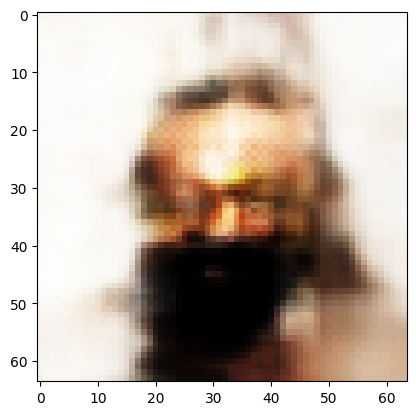

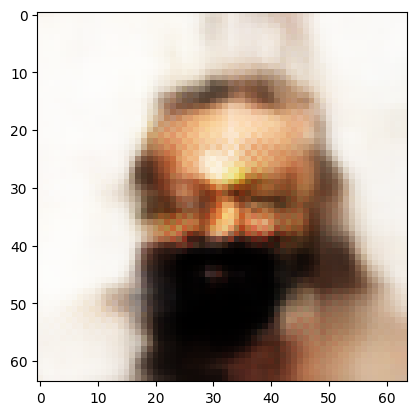

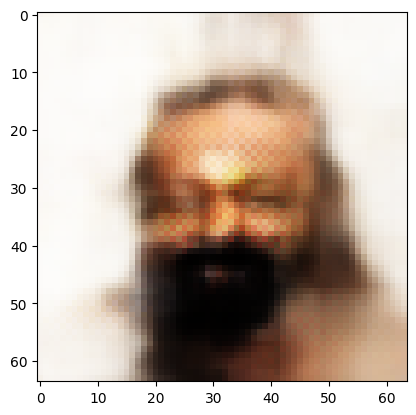

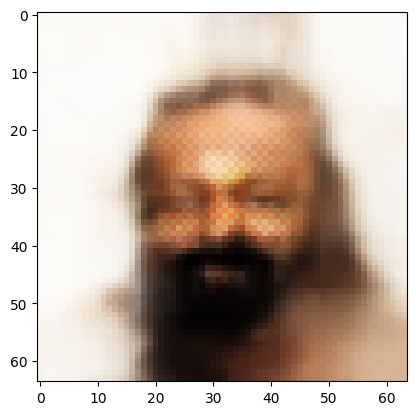

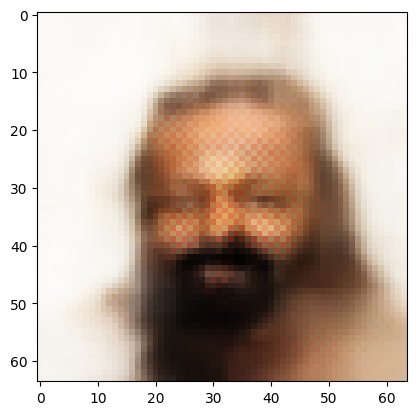

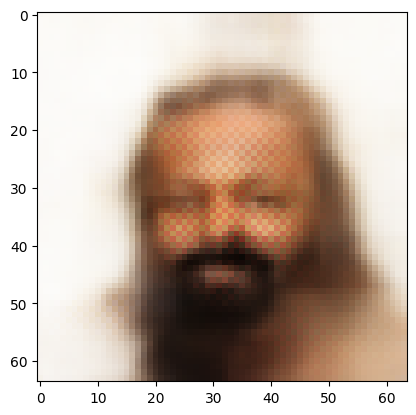

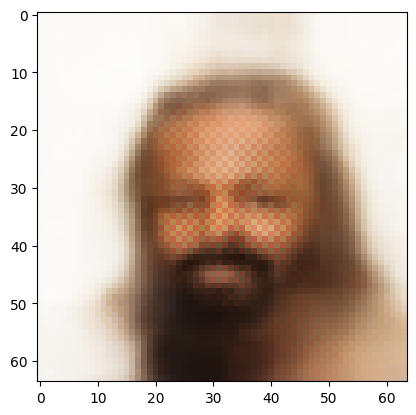

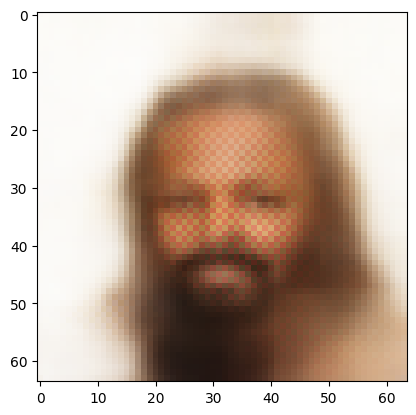

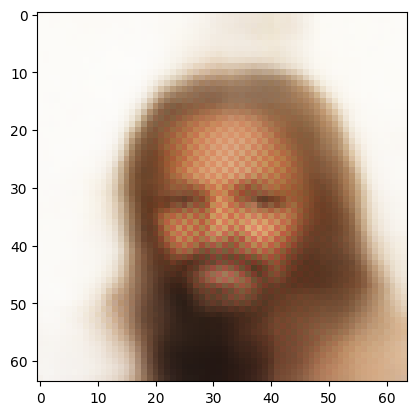

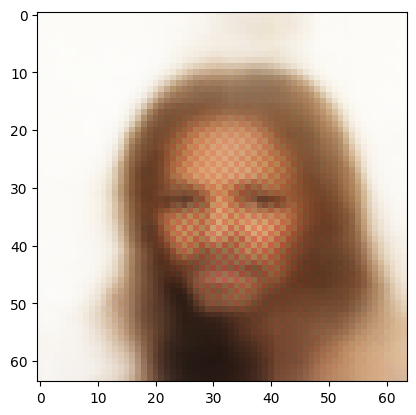

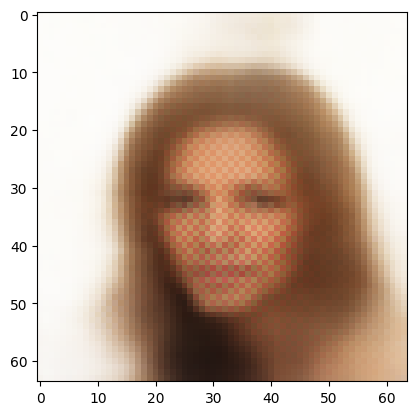

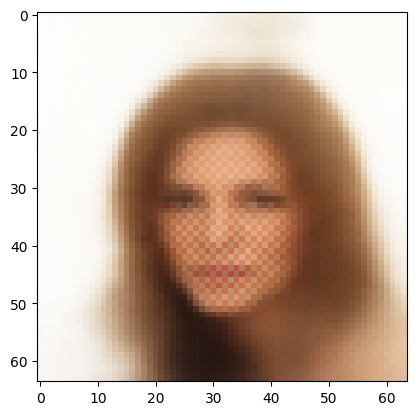

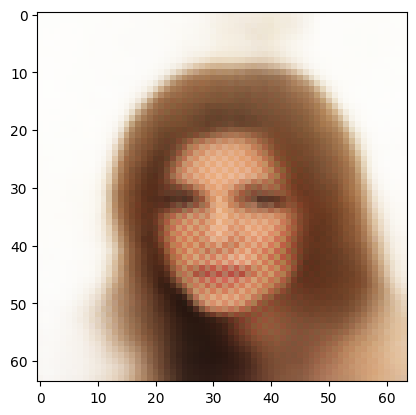

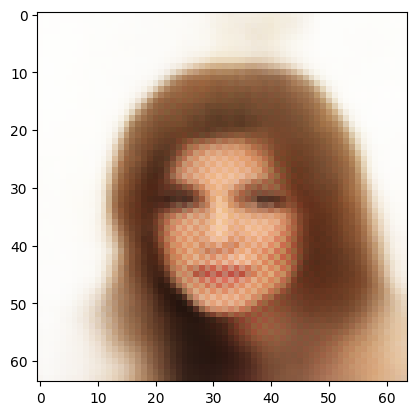

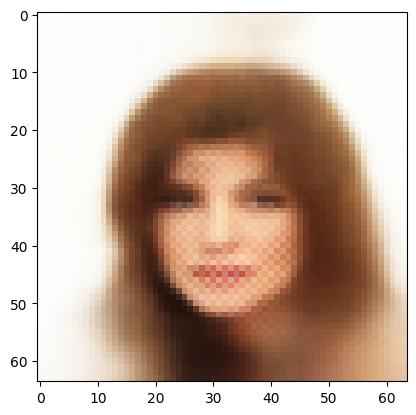

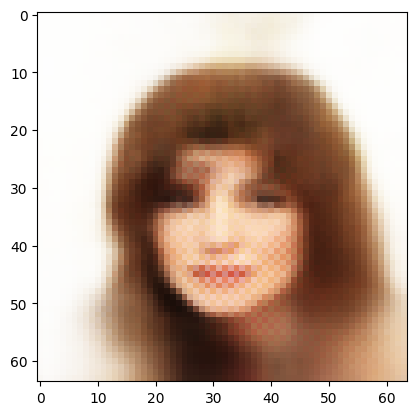

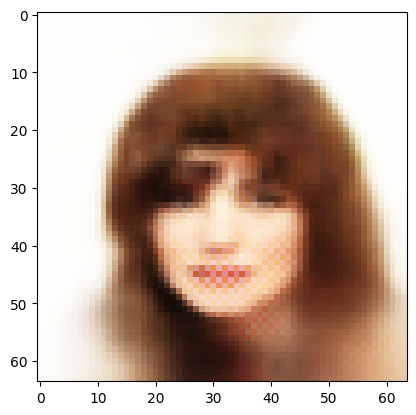

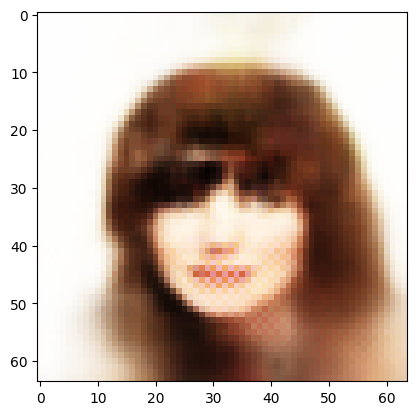

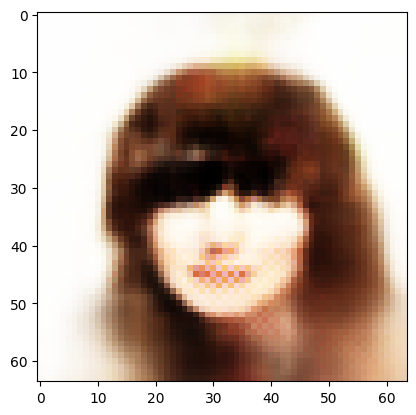

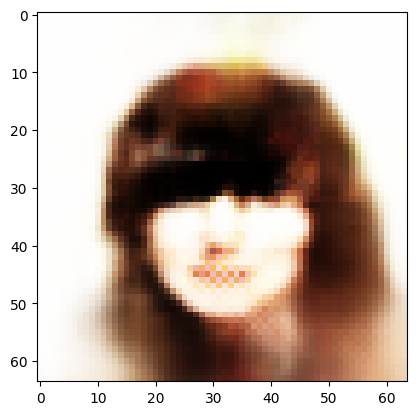

In [25]:
c = th.zeros(1, CONDITION_SIZE).to(device)

att_idx_1 = 10
att_idx_2 = 12
lim = 5
for i in range(20):
    c[0, att_idx_1] = 2 * lim * i / 20 - lim
    c[0, att_idx_2] = 2 * lim * (20 - i) / 20 - lim
    with th.no_grad():
        img = model.sample_eval(z=myz, c=c)
    _ = plt.imshow(img[0].permute(1, 2, 0).cpu().detach().numpy())
    plt.show()